In [2]:
#basic imports and ipython setup
import matplotlib.pyplot as plt
import numpy as np

import os.path

from MCEq.core import MCEqRun
import mceq_config as config
import crflux.models as pm

from tqdm import tqdm

import pandas as pd
from MCEq.geometry.density_profiles import GeneralizedTarget

import matplotlib as mpl
from cycler import cycler

In [3]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [4]:
def surface_flux(cosTH, primary_model = (pm.GlobalSplineFitBeta, None), interaction_model = 'DPMJETIII191', density_model = ('CORSIKA',('SouthPole', 'December')), elev = 3120, sol=True, use_tqdm=False):
    """ Sets up and runs an atmospheric MCEq calculation
    
    Parameters
    -----------
    cosTH : float bounded by (0., 1.]
        cosine of zenith angle
    
    primary_model : tuple
        MCEq primary model
        
    interaction_model : string
        MCEq interaction model
    
    density_model : tuple
        MCEq density model
        
    elev : int or float
        surface elevation in meters
        
    sol : bool
        Whether or not to solve the MCEq before returning
        
    use_tqdm : bool
        If True, runs a tqdm progress bar during integration
        
        
    Returns
    --------
    mceq : MCEqRun object
        MCEq instance specified by inputs
    """
    # configure MCEq
    import mceq_config as config
    
    config.debug_level = 0
    
    config.h_obs = elev # elevation in (m) of Dome-C
    
    config.enable_default_tracking = False
    
    #density_model = ('CORSIKA',('SouthPole', 'June'))
    #density_model = ('CORSIKA',('SouthPole', 'December'))
    #density_model = ('CORSIKA', ('USStd', None))
    
    config.max_density = 0.001225
    config.dedx_material = 'air'

    # initialize MCEq
    mceq = MCEqRun(
        interaction_model=interaction_model,
        theta_deg = 180*np.arccos(cosTH)/np.pi,
        density_model = density_model,
        #medium=medium,
        primary_model = primary_model,
    )
    
    if sol: # solve MCEq
        #mceq.solve()
        
        solve_mceq(mceq, use_tqdm=use_tqdm)
    
    return mceq

In [5]:
def depth_flux(flux, z, h, cosTH, rho, interaction_model = 'DPMJETIII191', sol=True, use_tqdm=False):
    """ Sets up and runs an underground ice MCEq calculation
    
    Parameters
    -----------
    flux : array of floats, final axis must match mceq._phi0
        incoming particle flux
        
    z : 1d array of floats
        initial depths of target material density bins, in meters
    
    h : 1d array of floats
        grid solution depths, in m.w.e. (hg/cm^2)
    
    cosTH : float bounded by (0., 1.]
        cosine of zenith angle
        
    rho : 1d array of floats, same size as z
        target material densities, in g/cm^3
        
    interaction_model : string
        MCEq interaction model
        
    sol : bool
        Whether or not to solve the MCEq before returning
        
    use_tqdm : bool
        If True, runs a tqdm progress bar during integration
        
        
    Returns
    --------
    mceq : MCEqRun object
        MCEq instance specified by inputs
    """
    # configure MCEq
    import mceq_config as config
    
    config.enable_default_tracking = False
    
    config.debug_level = 0 #2
    
    primary_model = (pm.GlobalSplineFitBeta, None)
    
    medium = 'ice'
    rho_ice = 0.9239 # density of solid ice at Dome C (g/cm^3)
    
    # setup ice density profile
    target = GeneralizedTarget(len_target=z[-1]*100/cosTH, env_density = rho_ice, env_name = 'ice')
    # manually enter all density layers at once because doing it one-by-one takes forever
    target.mat_list = [[z[i]*100/cosTH, z[i+1]*100/cosTH, rho[i], 'ice'] for i in range(len(z)-1)]
    target._update_variables()
        
    config.max_density = 0.9239
    config.dedx_material = 'ice'
    
    # initialize MCEq
    mceq = MCEqRun(
        interaction_model = interaction_model,
        theta_deg = 0,
        density_model = target,
        medium=medium,
        primary_model = primary_model,
    )

    mceq._phi0 = flux # set initial particle flux
    
    if sol: # solve MCEq
        #mceq.solve(int_grid=h/cosTH*100)
        
        solve_mceq(mceq, int_grid=h/cosTH*100, use_tqdm=use_tqdm)
    
    return mceq

In [6]:
def solve_mceq(mceq, int_grid=None, grid_var='X', use_tqdm=False):
    """ Runs numpy solver of MCEq, zeroing out values below 1e-250
    
    Parameters
    -----------
    mceq : MCEqRun object
        MCEq instance to be solved
    
    int_grid : 1d array of floats or None
        grid solution depths, in cm.w.e (g/cm^2)
    
    grid_var : str
        No idea what this does, just send it into mceq._calculate_integration_path
        
    use_tqdm : bool
        If True, runs a tqdm progress bar during integration
    """
    # Calculation is identical to MCEq numpy solver, except where noted
    
    mceq._calculate_integration_path(int_grid=int_grid, grid_var=grid_var)

    nsteps, dX, rho_inv, grid_idcs = mceq.integration_path
    int_m = mceq.int_m
    dec_m = mceq.dec_m

    dXaccum = 0.
    grid_sol = np.zeros((len(grid_idcs), *np.shape(mceq._phi0))) # grid_sol begins with the right shape, to avoid restructuring
    grid_step = 0

    phc = np.copy(mceq._phi0)
    
    for step in (tqdm(range(nsteps)) if use_tqdm else range(nsteps)): # added option for tqdm progress bar
        phc += (int_m.dot(phc) + dec_m.dot(rho_inv[step] * phc)) * dX[step]
        phc[phc<1e-250] = 0. # exreme low values set to 0, improving efficiency for large slant depths

        if (grid_idcs and grid_step < len(grid_idcs)
                and grid_idcs[grid_step] == step):
            grid_sol[grid_step] = np.copy(phc) # grid_sol no longer appends
            grid_step += 1

    mceq._solution, mceq.grid_sol = phc, grid_sol
    
    return

In [7]:
def flux_matrix_one_ang(particles, z, h, cosTH, rho, interaction_model = 'DPMJETIII191', density_model=('CORSIKA',('SouthPole', 'December')), elev = 3120, surf=True, depth=True):
    """ Solves for the muon spectrum from every possible primary particle energy, at a specific zenith angle
    
    Parameters
    -----------
    particles : 1d array of strings
        Names of primary particles used as input spectrum
        
    z : 1d array of floats
        initial depths of target material density bins, in meters
    
    h : 1d array of floats
        grid solution depths, in m.w.e. (hg/cm^2)
    
    cosTH : float bounded by (0., 1.]
        cosine of zenith angle
        
    rho : 1d array of floats, same size as z
        target material densities, in g/cm^3
        
    interaction_model : string
        MCEq interaction model
        
    elev : int or float
        surface elevation in meters
        
    surf : bool
        if False, skips atmospheric interactions
    
    depth : bool
        if False, skips underground ice interactions
        
    Returns
    --------
    phi_int : array of floats
        Muon spectra produced by primary particles, in #particles /cm^2 /sr /s
        axis0 : depth
        axis1 : muon energy
        axis2 : CR particle & energy
    """
    
    print('Calculating muon flux response at {:.1f} degrees'.format(180*np.arccos(cosTH)/np.pi))
    
    # initialize atmospheric MCEq
    mceq = surface_flux(cosTH, interaction_model=interaction_model, density_model=density_model, elev=elev, sol=False)
    
    pname = mceq.pman.pname2pref # reference for particle names and indices
    
    # range of particle indices used as primaries
    i_range = np.concatenate([np.arange(pname[p].lidx, pname[p].uidx) for p in particles])
    
    # setup 2d matrix of single-source fluxes
    phi0 = np.zeros((len(mceq._phi0), len(i_range))) # empty matrix
    phi0[i_range,np.arange(len(i_range))] = 1. # set flux=1 for a single primary particle energy per spectrum
    # axis0 : all particles & energies
    # axis1 : primary particles & energies
    
    if surf:
        print('Propagating through atmosphere...')
        # solve atmospheric MCEq for surface flux
        mceq._phi0 = phi0
        solve_mceq(mceq, use_tqdm=True)
    else:
        # skip atmospheric calculation
        mceq._solution = phi0
    
    if depth:
        print('Propagating through ice...')
        # solve in-ice MCEq for underground flux

        mceq_fin = depth_flux(mceq._solution, z, h, cosTH, rho, interaction_model = interaction_model, use_tqdm=True)
        
        print('Retrieving Muon Flux...')
        
        # calculate underground muon flux
        phi_sum = np.sum([mceq_fin.grid_sol[:, pname[mu].lidx:pname[mu].uidx] for mu in ['mu+_l', 'mu+', 'mu+_r', 'mu-_l', 'mu-', 'mu-_r']], axis=0) # sum all muon fluxes
        phi_int = phi_sum * mceq_fin._energy_grid.w.reshape((1,-1,1)) # multiply differential muon flux by energy bin width
    else:
        # skip in-ice calculation
        
        print('Retrieving Muon Flux...')
        
        # calculate surface flux
        phi_sum = np.sum([mceq._solution[pname[mu].lidx:pname[mu].uidx] for mu in ['mu+_l', 'mu+', 'mu+_r', 'mu-_l', 'mu-', 'mu-_r']], axis=0) # sum all muon fluxes
        phi_int = phi_sum * mceq._energy_grid.w.reshape((-1,1)) # multiply differential muon flux by energy bin width
        
    return phi_int

In [8]:
def flux_matrix_all(particles, z, h, cosTH, dcosTH, rho, interaction_model = 'DPMJETIII191', density_model=('CORSIKA',('SouthPole', 'December')), elev = 3120, surf=True, depth=True):
    """ Solves for the muon spectrum from every possible primary particle energy, integrated over a range of zenith angles
    
    Parameters
    -----------
    particles : 1d array of strings
        Names of primary particles used as input spectrum
        
    z : 1d array of floats
        initial depths of target material density bins, in meters
    
    h : 1d array of floats
        grid solution depths, in m.w.e. (hg/cm^2)
    
    cosTH : 1d array of floats
        cosine of zenith angle
        
    dcosTH : float or 1d array of floats (same size as cosTH)
        bin width of cosTH
        
    rho : 1d array of floats, same size as z
        target material densities, in g/cm^3
        
    interaction_model : string
        MCEq interaction model
        
    elev : int or float
        surface elevation in meters
        
    surf : bool
        if False, skips atmospheric interactions
    
    depth : bool
        if False, skips underground ice interactions and returns surface spectrum without integrating over cosTH
        
    Returns
    --------
    phi_int : array of floats
        Muon spectra produced by primary particles, in #particles /cm^2 /sr /s
        axis0 : depth
        axis1 : muon energy
        axis2 : CR particle & energy
    """
    
    if not (surf and depth):
        # calculate surface spectrum over cosTH range
        return np.array([flux_matrix_one_ang(particles, z, h, cth, rho, interaction_model = interaction_model, density_model=density_model, elev = elev, surf=surf, depth=depth) for cth in cosTH])
    else:
        # integrate longitudinal muon spectrum over cosTH range
        phi_mu_tot = flux_matrix_one_ang(particles, z, h, cosTH[0], rho, interaction_model = interaction_model, density_model=density_model, elev = elev, surf=surf, depth=depth)
        phi_mu_tot *= dcosTH
        for i in range(1,len(cosTH)):
            phi_mu_tot += flux_matrix_one_ang(particles, z, h, cosTH[i], rho, interaction_model = interaction_model, density_model=density_model, elev = elev, surf=surf, depth=depth) * dcosTH
    
    return 2*np.pi*phi_mu_tot

In [9]:
age_scale_file = 'DomeC_age_scale_Apr2023.csv' # relationship between age and depth of ice at Dome-C
ice_eq_depth_file = 'Real_vs_ice_eq_depth.csv' # relationship bewteen ice-equivalent-depth and real-depth at Dome-C

# read age-scale file
age_scale = pd.read_csv(age_scale_file)
ages = np.array(age_scale['ages']) # years
depths_real = np.array(age_scale['depths_real']) # meters

# read ice-eq-depth file
ice_eq_depth = pd.read_csv(ice_eq_depth_file)
real_z = ice_eq_depth['z'] # meters
ice_eq_z = ice_eq_depth['ice_eq_z'] # meters (ice-eq) aka mass-depth / ice density

In [10]:
rho_ice = 0.9239 # density of solid ice at Dome C (g/cm^3)

def z_to_t(z): # convert real depth to age
    return np.interp(z, depths_real, ages)

def t_to_z(t): # convert age to real depth
    return np.interp(t, ages, depths_real)

def z_to_h(z): # convert real depth to mass depth
    return np.interp(z, real_z, ice_eq_z)*rho_ice

def h_to_z(h): # convert mass depth to real depth
    return np.interp(h/rho_ice, ice_eq_z, real_z)

def h_to_t(h): # convert mass depth to age
    return z_to_t(h_to_z(h/rho_ice))

def t_to_h(t): # convert age to mass depth
    return z_to_h(t_to_z(t))*rho_ice

Text(0.5, 1.0, 'Ice Depth by Relative Age')

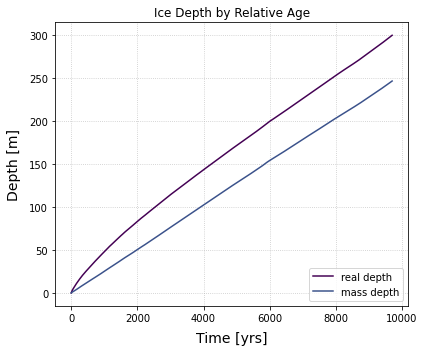

In [11]:
z_min = 0 # starting depth for plots (m)
z_start = 96.5 # starting depth of 14C accumulation (m) - close-off depth beneath firn layer
z_deep = 300 # end depth (m)

i_min = np.argmin(abs(depths_real-z_min)) # nearest depths_real index to z_min
i_start = np.argmin(abs(depths_real-z_start)) # nearest depths_real index to z_start
i_end = np.argmin(abs(depths_real-z_deep)) # nearest depths_real index to z_end

z = depths_real[i_min:i_end+1] # depth array in steps of 1-year ice age (m)
dz = depths_real[i_min+1:i_end+2] - z # bin-width of z (m)

i_int = np.arange(i_start-i_min, i_end-i_min+1) # indices of z beneath starting point for 14C accumulation

h = z_to_h(z) # mass depth corresponding to z array (m.w.e = hg/cm^2)
dh = z_to_h(depths_real[i_min+1:i_end+2]) - h # bin-width of h (m.w.e = hg/cm^2)

t = np.arange(len(z)) # ice age corresponding to z array (years)
dt = 1 # bin-width of t (years)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, z, label='real depth')
ax.plot(t, h, label='mass depth')
ax.set(xlabel='Time [yrs]',
       ylabel='Depth [m]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Depth by Relative Age')

Text(0.5, 1.0, 'Ice Density Profile')

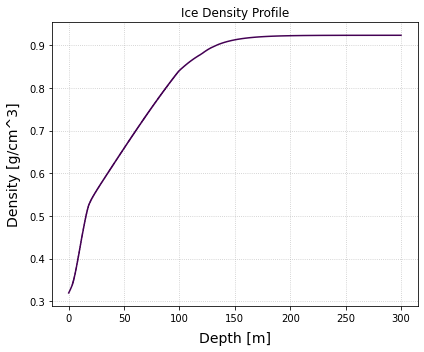

In [12]:
rho = dh/dz # calculate density from change in mass depth / real depth

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(z, rho)
ax.set(xlabel='Depth [m]',
       ylabel='Density [g/cm^3]')
#ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Density Profile')

In [13]:
# pick an interaction_model for MCEq

interaction_model = "SIBYLL-2.3c"
#interaction_model = "SIBYLL-2.3"
#interaction_model = "SIBYLL-2.1"
#interaction_model = "EPOS-LHC"
#interaction_model = "QGSJET-II-04"
#interaction_model = "DPMJET-III"
#interaction_model = 'DPMJETIII191'

In [14]:
#density_model, density_name = ('CORSIKA',('SouthPole', 'June')), "CORSIKA-SouthPole-June"
#density_model, density_name = ('CORSIKA',('SouthPole', 'December')), "CORSIKA-SouthPole-December"
#density_model, density_name = ('AIRS', ('SouthPole', 'June')), "AIRS-SouthPole-June"
#density_model, density_name = ('AIRS', ('SouthPole', 'December')), "AIRS-SouthPole-December"
density_model, density_name = ('CORSIKA', ('USStd', None)), "CORSIKA-USStd"

In [15]:
# Setup range of zenith angles for integration to total flux
zenith_center = "upper"
#zenith_center = "center"

dcosTH = 0.1
cosTH = np.arange(1,0,-dcosTH) # cosines of zenith angles in evenly space bins
if zenith_center == "center":
    cosTH -= 0.05

In [16]:
#elev = 3120
elev = 0

In [17]:
# obtain matrix for surface muon spectrum from primary CR

f_surf = 'flux_surf_{}_{}_{}_{}m.npy'.format(interaction_model, density_name, zenith_center, elev)
if os.path.isfile(f_surf): # attempt to load past data
    phi_mu_surf = np.load(f_surf)
else: # run new calculation & save
    phi_mu_surf = flux_matrix_all(['p+', 'n0'], z, h, cosTH, dcosTH, rho=rho, interaction_model = interaction_model, density_model=density_model, elev = elev, depth=False)
    np.save(f_surf, phi_mu_surf)

Calculating muon flux response at 0.0 degrees
Propagating through atmosphere...


100%|████████████████████████████████████████████████████████████████████████████████| 594/594 [02:01<00:00,  4.89it/s]


Retrieving Muon Flux...
Calculating muon flux response at 25.8 degrees
Propagating through atmosphere...


100%|████████████████████████████████████████████████████████████████████████████████| 658/658 [02:19<00:00,  4.72it/s]


Retrieving Muon Flux...
Calculating muon flux response at 36.9 degrees
Propagating through atmosphere...


100%|████████████████████████████████████████████████████████████████████████████████| 737/737 [02:36<00:00,  4.70it/s]


Retrieving Muon Flux...
Calculating muon flux response at 45.6 degrees
Propagating through atmosphere...


100%|████████████████████████████████████████████████████████████████████████████████| 838/838 [02:59<00:00,  4.66it/s]


Retrieving Muon Flux...
Calculating muon flux response at 53.1 degrees
Propagating through atmosphere...


100%|████████████████████████████████████████████████████████████████████████████████| 971/971 [03:31<00:00,  4.60it/s]


Retrieving Muon Flux...
Calculating muon flux response at 60.0 degrees
Propagating through atmosphere...


100%|██████████████████████████████████████████████████████████████████████████████| 1153/1153 [04:16<00:00,  4.50it/s]


Retrieving Muon Flux...
Calculating muon flux response at 66.4 degrees
Propagating through atmosphere...


100%|██████████████████████████████████████████████████████████████████████████████| 1416/1416 [05:06<00:00,  4.61it/s]


Retrieving Muon Flux...
Calculating muon flux response at 72.5 degrees
Propagating through atmosphere...


100%|██████████████████████████████████████████████████████████████████████████████| 1823/1823 [06:35<00:00,  4.61it/s]


Retrieving Muon Flux...
Calculating muon flux response at 78.5 degrees
Propagating through atmosphere...


100%|██████████████████████████████████████████████████████████████████████████████| 2520/2520 [09:04<00:00,  4.63it/s]


Retrieving Muon Flux...
Calculating muon flux response at 84.3 degrees
Propagating through atmosphere...


100%|██████████████████████████████████████████████████████████████████████████████| 3871/3871 [13:59<00:00,  4.61it/s]

Retrieving Muon Flux...


In [18]:
np.shape(phi_mu_surf)

(10, 121, 242)

In [19]:
def split_Haino(h):
    if '×' in h:
        x,e = h.split('×')
        e = int(e[2:].replace('−','-'))
    else:
        x,e = h,0
    a = np.array(x.split('±'), dtype=float)
    a *= 10**e
    return a

In [20]:
Haino2004 = pd.read_csv('Muon Spectrum Tables/Haino2004_Table3_raw.csv')
p_range_H04 = np.array([h.split('–') for h in Haino2004['Momentum Range']], dtype=float) # GeV/c
P_avg_mu_pos_H04 = np.array(Haino2004['mu+ P_avg']) # GeV/c
P_avg_mu_neg_H04 = np.array(Haino2004['mu- P_avg']) # GeV/c
F_mu_pos_H04 = np.array([split_Haino(h) for h in Haino2004['mu+ Flux, dF_stat, dF_sys']]) # (m^2 sr s GeV/c)^-1
F_mu_neg_H04 = np.array([split_Haino(h) for h in Haino2004['mu- Flux, dF_stat, dF_sys']]) # (m^2 sr s GeV/c)^-1

In [21]:
DePascale93 = pd.read_csv('Muon Spectrum Tables/DePascale1993_Table3_raw.csv')
p_min_DP93, p_max_DP93, p_avg_DP93, N_mu_neg_DP93, N_mu_pos_DP93 = np.array([d.split() for d in DePascale93['Rigidity (GV/c) Minimum | Maximum | Median | N Observed Mu- | N Observed Mu+']], dtype=float).T
F_mu_neg_DP93, rel_err_neg_DP93 = np.array([d.replace('(','').replace(')','').split() for d in DePascale93['Differential Flux mu- (m^2 s sr GV/c)^-1 | % Error']], dtype=float).T
rel_err_neg_DP93 = rel_err_neg_DP93/100
F_neg_err_DP93 = F_mu_neg_DP93 * rel_err_neg_DP93
F_mu_pos_DP93, rel_err_pos_DP93 = np.array([d.replace('(','').replace(')','').split() for d in DePascale93['Differential Flux mu+ (m^2 s sr GV/c)^-1 | % Error']], dtype=float).T
rel_err_pos_DP93 = rel_err_pos_DP93/100
F_pos_err_DP93 = F_mu_pos_DP93 * rel_err_pos_DP93

In [22]:
def split_Kremer(k):
    K = k.replace('–',' ').split()
    p_min = float(K[0])
    p_max = float(K[1])
    p_avg = float(K[2])
    if len(K)<23:
        F_pos_94 = float(K[3])
        F_pos_94_err = float(K[5])
        F_neg_94 = float(K[6])
        F_neg_94_err = float(K[8])
        if len(K)==12:
            F_pos_97 = 0.
            F_pos_97_err = 0.
            F_neg_97 = float(K[9])
            F_neg_97_err = float(K[11])
        else:
            F_pos_97 = float(K[9])
            F_pos_97_err = float(K[11])
            F_neg_97 = float(K[12])
            F_neg_97_err = float(K[14])
    else:
        exp_pos_94 = 10.**(int(K[7][-1]) * (-1 if len(K[7])>3 else 1))
        F_pos_94 = float(K[3])*exp_pos_94
        F_pos_94_err = float(K[5])*exp_pos_94
        exp_neg_94 = 10.**(int(K[12][-1]) * (-1 if len(K[12])>3 else 1))
        F_neg_94 = float(K[8])*exp_neg_94
        F_neg_94_err = float(K[10])*exp_neg_94
        exp_pos_97 = 10.**(int(K[17][-1]) * (-1 if len(K[17])>3 else 1))
        F_pos_97 = float(K[13])*exp_pos_97
        F_pos_97_err = float(K[15])*exp_pos_97
        exp_neg_97 = 10.**(int(K[22][-1]) * (-1 if len(K[22])>3 else 1))
        F_neg_97 = float(K[18])*exp_neg_97
        F_neg_97_err = float(K[20])*exp_neg_97
    return [p_min, p_max, p_avg, F_pos_94, F_pos_94_err, F_neg_94, F_neg_94_err, F_pos_97, F_pos_97_err, F_neg_97, F_neg_97_err]

In [23]:
Kremer99 = pd.read_csv('Muon Spectrum Tables/Kremer1999_Table1_raw.csv')
p_min_K99, p_max_K99, p_avg_K99, F_mu_pos_K99_94, F_pos_err_K99_94, F_mu_neg_K99_94, F_neg_err_K99_94, F_mu_pos_K99_97, F_pos_err_K99_97, F_mu_neg_K99_97, F_neg_err_K99_97 = np.array([split_Kremer(k) for k in Kremer99['Momentum (GeV/c) Min | Max | Mean | CAPRICE94 mu+ (GeV/c m^2 s sr)^-1 | mu- | CAPRICE97 mu+ (GeV/c m^2 s sr)^-1 | mu-']]).T
K99_clip = F_mu_pos_K99_97>0.
F_mu_tot_K99_94 = F_mu_pos_K99_94+F_mu_neg_K99_94
F_mu_err_K99_94 = np.sqrt(F_pos_err_K99_94**2 + F_neg_err_K99_94**2)
p_avg_K99_97 = p_avg_K99[K99_clip]
F_mu_tot_K99_97 = (F_mu_pos_K99_97+F_mu_neg_K99_97)[K99_clip]
F_mu_err_K99_97 = np.sqrt(F_pos_err_K99_97**2 + F_neg_err_K99_97**2)[K99_clip]

In [24]:
#primary_model, primary_name = (pm.GlobalSplineFitBeta, None), 'GSFB'
primary_model, primary_name = (pm.HillasGaisser2012, "H3a"), 'HG2012'

In [25]:
mceq = surface_flux(1, primary_model = (pm.GlobalSplineFitBeta, None), interaction_model=interaction_model, density_model=('CORSIKA', ('USStd', None)), elev = 0, use_tqdm=True)

100%|███████████████████████████████████████████████████████████████████████████████| 594/594 [00:01<00:00, 312.70it/s]


In [26]:
E_grid = mceq.e_grid

In [27]:
mceq_mu_neg = mceq.get_solution('mu-', integrate=False)
mceq_mu_pos = mceq.get_solution('mu+', integrate=False)
mceq_mu_tot = mceq_mu_neg + mceq_mu_pos

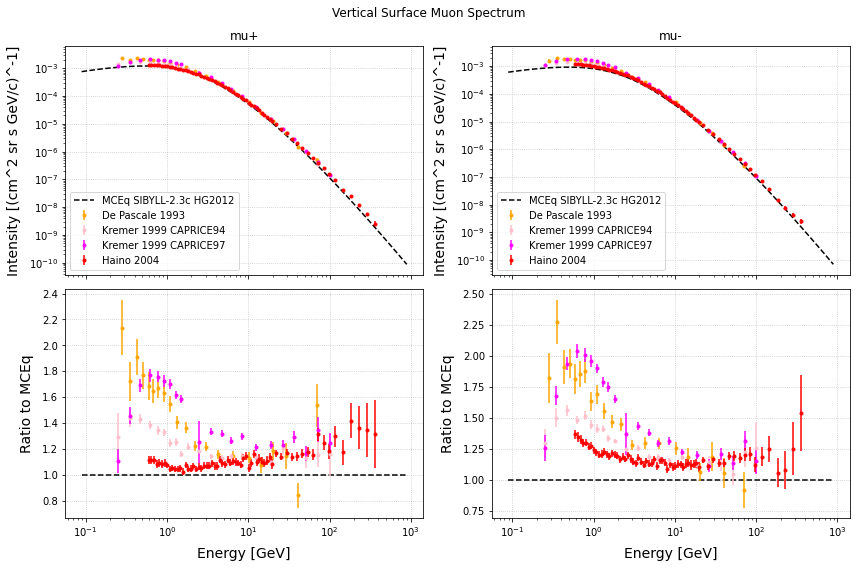

In [28]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,8), tight_layout=True, sharex=True)

ax1.errorbar(p_avg_DP93, F_mu_pos_DP93*1e-4, yerr=F_pos_err_DP93*1e-4, c='orange', fmt='.', label='De Pascale 1993')
ax1.errorbar(p_avg_K99, F_mu_pos_K99_94*1e-4, yerr=F_pos_err_K99_94*1e-4, c='pink', fmt='.', label='Kremer 1999 CAPRICE94')
ax1.errorbar(p_avg_K99[K99_clip], F_mu_pos_K99_97[K99_clip]*1e-4, yerr=F_pos_err_K99_97[K99_clip]*1e-4, c='magenta', fmt='.', label='Kremer 1999 CAPRICE97')
ax1.errorbar(P_avg_mu_pos_H04, F_mu_pos_H04[:,0]*1e-4, yerr=np.sqrt(np.sum(F_mu_pos_H04[:,1:]**2,axis=1))*1e-4, c='r', fmt='.', label='Haino 2004')
ax1.plot(E_grid[E_grid<1e3], mceq_mu_pos[E_grid<1e3], c='black', ls='--', label='MCEq {} {}'.format(interaction_model, primary_name))
ax3.plot(E_grid[E_grid<1e3], mceq_mu_pos[E_grid<1e3]/mceq_mu_pos[E_grid<1e3], c='black', ls='--')
ax3.errorbar(p_avg_DP93, F_mu_pos_DP93*1e-4/np.interp(p_avg_DP93, E_grid, mceq_mu_pos), yerr=F_pos_err_DP93*1e-4/np.interp(p_avg_DP93, E_grid, mceq_mu_pos), fmt='.', c='orange')
ax3.errorbar(p_avg_K99, F_mu_pos_K99_94*1e-4/np.interp(p_avg_K99, E_grid, mceq_mu_pos), yerr=F_pos_err_K99_94*1e-4/np.interp(p_avg_K99, E_grid, mceq_mu_pos), fmt='.', c='pink')
ax3.errorbar(p_avg_K99[K99_clip], F_mu_pos_K99_97[K99_clip]*1e-4/np.interp(p_avg_K99[K99_clip], E_grid, mceq_mu_pos), yerr=F_pos_err_K99_97[K99_clip]*1e-4/np.interp(p_avg_K99[K99_clip], E_grid, mceq_mu_pos), fmt='.', c='magenta')
ax3.errorbar(P_avg_mu_pos_H04, F_mu_pos_H04[:,0]*1e-4/np.interp(P_avg_mu_pos_H04, E_grid, mceq_mu_pos), yerr=np.sqrt(np.sum(F_mu_pos_H04[:,1:]**2,axis=1))*1e-4/np.interp(P_avg_mu_pos_H04, E_grid, mceq_mu_pos), fmt='.', c='r')

ax2.errorbar(p_avg_DP93, F_mu_neg_DP93*1e-4, yerr=F_neg_err_DP93*1e-4, c='orange', fmt='.', label='De Pascale 1993')
ax2.errorbar(p_avg_K99, F_mu_neg_K99_94*1e-4, yerr=F_neg_err_K99_94*1e-4, c='pink', fmt='.', label='Kremer 1999 CAPRICE94')
ax2.errorbar(p_avg_K99, F_mu_neg_K99_97*1e-4, yerr=F_neg_err_K99_97*1e-4, c='magenta', fmt='.', label='Kremer 1999 CAPRICE97')
ax2.errorbar(P_avg_mu_neg_H04, F_mu_neg_H04[:,0]*1e-4, yerr=np.sqrt(np.sum(F_mu_neg_H04[:,1:]**2,axis=1))*1e-4, c='r', fmt='.', label='Haino 2004')
ax2.plot(E_grid[E_grid<1e3], mceq_mu_neg[E_grid<1e3], c='black', ls='--', label='MCEq {} {}'.format(interaction_model, primary_name))
ax4.plot(E_grid[E_grid<1e3], mceq_mu_neg[E_grid<1e3]/mceq_mu_neg[E_grid<1e3], c='black', ls='--')
ax4.errorbar(p_avg_DP93, F_mu_neg_DP93*1e-4/np.interp(p_avg_DP93, E_grid, mceq_mu_neg), yerr=F_neg_err_DP93*1e-4/np.interp(p_avg_DP93, E_grid, mceq_mu_neg), fmt='.', c='orange')
ax4.errorbar(p_avg_K99, F_mu_neg_K99_94*1e-4/np.interp(p_avg_K99, E_grid, mceq_mu_neg), yerr=F_neg_err_K99_94*1e-4/np.interp(p_avg_K99, E_grid, mceq_mu_neg), fmt='.', c='pink')
ax4.errorbar(p_avg_K99, F_mu_neg_K99_97*1e-4/np.interp(p_avg_K99, E_grid, mceq_mu_neg), yerr=F_neg_err_K99_97*1e-4/np.interp(p_avg_K99, E_grid, mceq_mu_neg), fmt='.', c='magenta')
ax4.errorbar(P_avg_mu_neg_H04, F_mu_neg_H04[:,0]*1e-4/np.interp(P_avg_mu_neg_H04, E_grid, mceq_mu_neg), yerr=np.sqrt(np.sum(F_mu_neg_H04[:,1:]**2,axis=1))*1e-4/np.interp(P_avg_mu_neg_H04, E_grid, mceq_mu_neg), fmt='.', c='r')

ax1.set(xscale = 'log',
       yscale = 'log',
       ylabel='Intensity [(cm^2 sr s GeV/c)^-1]')
ax1.legend(loc='lower left', fontsize=10)
ax1.title.set_text('mu+')

ax2.set(xscale = 'log',
       yscale = 'log',
       ylabel='Intensity [(cm^2 sr s GeV/c)^-1]')
ax2.legend(loc='lower left', fontsize=10)
ax2.title.set_text('mu-')

ax3.set(xscale = 'log',
       xlabel='Energy [GeV]',
       ylabel='Ratio to MCEq')

ax4.set(xscale = 'log',
       xlabel='Energy [GeV]',
       ylabel='Ratio to MCEq')

plt.suptitle('Vertical Surface Muon Spectrum')
plt.show()

In [29]:
A_G = 0.14 #scale factor
gamma = 2.7 #index of energy spectrum
epsilon_pi = 115/1.1 #critical energy of pion (GeV)
epsilon_K = 850/1.1 #critical energy of kaon (GeV)
B_G = 0.054 # ratio factor between pion and kaon produced muons

def gaisser(E0, cosTH):
    # surface flux calculation
    Phi_G = A_G * E0**(-gamma) * (1/(1+E0*cosTH/epsilon_pi) + B_G/(1+E0*cosTH/epsilon_K))
    
    return Phi_G
    
def gaisser_tang(E0, cosTH):
    #cosTH_mod parameters
    p1 = 0.102573
    p2 = -0.068287
    p3 = 0.958633
    p4 = 0.0407253
    p5 = 0.817285
    
    #modified cosine to account for atmospheric curvature
    cosTH_mod = np.sqrt((cosTH**2 + p1**2 + p2*cosTH**p3 + p4*cosTH**p5)/(1+p1**2+p2+p4))
    
    #piecewise scale factor
    A_T = 1 * (E0 > 100/cosTH_mod) + 1.1 * (90 * np.sqrt(cosTH+0.001)/1030)**(4.5/(E0*cosTH_mod)) * (E0 <= 100/cosTH_mod)
    
    #proportion of prompt muons produced by the decay of charmed particles
    r_c = 10**(-4) * (E0 <= 100/cosTH_mod)
    
    E0_hat = E0 + 2.06e-3 * (950/cosTH_mod - 90)
    
    Phi_T = A_T * A_G * E0**(-gamma) * (1/(1+E0_hat*cosTH_mod/epsilon_pi) + B_G/(1+E0_hat*cosTH_mod/epsilon_K) + r_c)
    
    return Phi_T

In [30]:
def bugaev_reyna(E0, cosTH):
    A_B = 0.00253
    a0 = 0.2455
    a1 = 1.288
    a2 = -0.2555
    a3 = 0.0209
    
    y = np.log10(E0*cosTH)
    
    Phi_R = cosTH**3 * A_B * (E0*cosTH)**(-(a3*y**3 + a2*y**2 + a1*y + a0))
    
    return Phi_R

In [31]:
def judge_nash(E0, cosTH):
    H_pi = 114 #GeV
    H_K = 851 #GeV
    gamma_pi = 2.7
    gamma_K = gamma_pi
    A_pi = 0.28
    A_K = 0.0455
    y0 = 1000 # Atmosphere depth at sea level? (g/cm^2)
    r_pi = 0.76 #muon to parent pion energy ratio
    r_K = 0.523 #muon to parent kaon energy ratio
    q = 2.2e-3 #mean energy loss of the muon in the atmosphere (GeV cm^2/g)
    tau_mu = 2.2e-6 #mean muon lifetime (s)
    tau_pi = 2.61e-8 #mean pion lifetime (s)
    tau_K = 1.24e-8 #mean kaon lifetime (s)
    g = 981.3 #acceleration due to gravity (cm/s^2)
    R = 8.314e7 #gas constant (g cm^2/s^2 /K /mol)
    m_mu = 105.659e-3 #muon rest mass (GeV/c^2)
    m_pi = 139.580e-3 #pion rest mass (GeV/c^2)
    m_K = 493.800e-3 #kaon rest mass (GeV/c^2)
    c = 3e10 #speed of light (cm/s)
    M = 28.966 #effective molecular weight of air (g/mol)
    
    #effective mean temperature of the atmosphere as experienced at zenith angle theta
    T_e = 220 #220 #from Chatzidakis 2015
    
    H_mu = R*m_mu*T_e / c / M / g / tau_mu
    
    E_pi = (E0 + q*y0*(1/cosTH - 0.0874))/r_pi
    
    #H_pi = R*m_pi*c*T_e / M/g/tau_pi
    
    W_pi = (0.0874 * cosTH * (1- q * (y0/cosTH - 90)/r_pi/E_pi))**(H_mu/cosTH/(r_pi*E_pi+90*q))
    
    E_K = (E0 + q*y0*(1/cosTH - 0.0874))/r_K
    
    #H_K = R*m_K*c*T_e / M / g /tau_K
    
    W_K = (0.0874 * cosTH * (1- q * (y0/cosTH - 0.0874)/r_K/E_K))**(H_mu/cosTH/(r_K*E_K+90*q))
    
    Phi_J = A_pi*W_pi*E_pi**(-gamma_pi)*H_pi / (E_pi*cosTH + H_pi) + A_K*W_K*E_K**(-gamma_K)*H_K / (E_K*cosTH + H_K)
    
    return Phi_J

In [32]:
def SDC(E0, cosTH):
    # Smith & Duller / Chatzidakis
    
    A = 0.002382 # fitting parameter
    r = 0.76 # Ratio of muon energy to pion energy
    a = 2.500e-3 # Muon rate of energy loss in air (GeV / (g/cm^2))
    y0 = 1000 # Atmosphere depth at sea level (g/cm^2)
    gamma = 8/3 # fitting parameter
    b_mu = 0.800 # Correction factor related to atmospheric temperature
    m_mu = 105.659e-3 # Rest mass of muon (GeV/c^2)
    tau_mu0 = 2.2e-6 # Mean lifetime of muon at rest (s)
    rho0 = 0.00123 # Density of atmosphere at sea level (g/cm^3)
    c = 3e10 # speed of light (cm/s)
    lambda_pi = 120 # Absorption mean free path of pions (g/cm^2)
    b = 0.771 # coefficient to modify the isothermal atmosphere approximation
    tau0 = 2.61e-8 # Mean lifetime of pion at rest (s)
    m_pi = 139.580e-3 # Rest mass of pion (GeV/c^2)
    j_pi = 148.16 # m_pi * y0 * c / (tau0 * rho0) GeV
    
    # energy of pion that produced muon
    E_pi = (E0 + a*y0*(1/cosTH - 0.100))/r
    
    B_mu = b_mu * m_mu * y0 / (c * tau_mu0 * rho0)
    
    # Probability for muons to reach sea level
    P_mu = (0.100 * cosTH * (1-a*(y0/cosTH - 100)/(r * E_pi)))**(B_mu / ((r*E_pi + 100*a)*cosTH))
    
    Phi_S = A * E_pi**(-gamma) * P_mu * lambda_pi * b * j_pi/(E_pi* cosTH + b * j_pi)
    
    return Phi_S

In [33]:
F_SDC = SDC(E_grid, 1)
F_G = gaisser(E_grid, 1)
F_BR = bugaev_reyna(E_grid, 1)
F_JN = judge_nash(E_grid, 1)

C:\Users\walte\AppData\Local\Temp/ipykernel_17780/735983733.py:38: RuntimeWarning: invalid value encountered in power
  W_K = (0.0874 * cosTH * (1- q * (y0/cosTH - 0.0874)/r_K/E_K))**(H_mu/cosTH/(r_K*E_K+90*q))


In [34]:
def allkofer_split(a):
    b = a.replace('(','').replace(')','').replace(' ±','').replace(' x','').split(' ')
    return [float(b[0])*10**(int(b[3])), float(b[1])*10**(int(b[3])), float(b[4]), float(b[5]), float(b[6])]

In [35]:
# Measured at Kiel
Allkofer1971 = pd.read_csv('Muon Spectrum Tables/Allkofer1971_Table1_raw.csv')
p_min_A71, p_max_A71, p_avg_A71 = np.array([a.replace('-','').split(' ') for a in Allkofer1971['Momentum Range | Mean (GeV/c)']], dtype=float).T
F_mu_tot_A71, F_mu_err_A71, rel_err_A71, N_obs_A71, rel_accept_A71 = np.array([allkofer_split(a) for a in Allkofer1971['Differential Intensity (cm^2 sr s GeV/c)^-1 | Relative Error (%) | Number of measured particles | Relative Acceptance']]).T

In [36]:
Ayre75 = pd.read_csv('Muon Spectrum Tables/Ayre1975_Table8_raw.csv')
p_avg_A75 = Ayre75['Momentum (GeV/c)']
F_mu_tot_A75 = Ayre75['Differential Spectrum (s cm^2 sr (GeV/c))^-1']
F_mu_err_A75 = Ayre75['Differential Spectrum Error']
I_mu_tot_A75 = Ayre75['Integral Spectrum (s cm^2 sr)^-1']
I_mu_err_A75 = Ayre75['Integral Spectrum Error']

In [37]:
Barber68 = pd.read_csv('Muon Spectrum Tables/Barber1968_Table2_raw.csv')
B = np.array([b.replace('x ','').split() for b in Barber68['Momentum (GeV/c) | Differential intensity (cm^2 s sr (GeV/c))^-1 | Statistical error (%)']])
p_avg_B68 = B[:,0].astype(float)
F_mu_tot_B68 = B[:,1].astype(float)*10.**B[:,3].astype(int)
rel_err_B68 = B[:,4].astype(float)/100
F_mu_err_B68 = F_mu_tot_B68*rel_err_B68

In [38]:
# Kiel-Desy at Hamburg
# Zenith angle 75 degrees (68-82 range)
Jokisch79 = pd.read_csv('Muon Spectrum Tables/Jokisch1979_Table2_raw.csv')
p_avg_J79 = np.array(Jokisch79['Momentum (GeV/c)'])
F_mu_75_J79 = np.array(Jokisch79['Intensity (cm^2 s sr GeV/c)^-1'])
rel_err_J79 = np.array(Jokisch79['Error (%)'])/100
N_obs_J79 = np.array(Jokisch79['Measured Number'])
F_err_75_J79 = F_mu_75_J79*rel_err_J79

In [39]:
Kellogg78 = pd.read_csv('Muon Spectrum Tables/Kellogg1978_Table9_raw.csv')
p_avg_K78 = np.array(Kellogg78['Momentum (GeV)'])
F_mu_75_K78 = np.array(Kellogg78['75 deg Flux (m^2 s sr GeV)^-1'])
F_err_75_K78 = np.array(Kellogg78['75 deg Error'])
F_mu_30_K78 = np.array(Kellogg78['30 deg Flux (m^2 s sr GeV)^-1'])
F_err_30_K78 = np.array(Kellogg78['30 deg Error'])

In [40]:
Nandi72 = pd.read_csv('Muon Spectrum Tables/Nandi1972_Table2_raw.csv')
p_avg_N72 = np.array(Nandi72['Median Momentum (GeV/c)'])
N_obs_N72 = np.array(Nandi72['Number of Particles Observed'])
F_mu_tot_N72 = np.array(Nandi72['Differential Intensity (cm^2 s sr GeV/c)^-1'])
rel_err_N72 = (np.array(Nandi72['Statistical Error (+%)']) + np.array(Nandi72['Statistical Error (-%)']))/200
F_mu_err_N72 = F_mu_tot_N72 * rel_err_N72

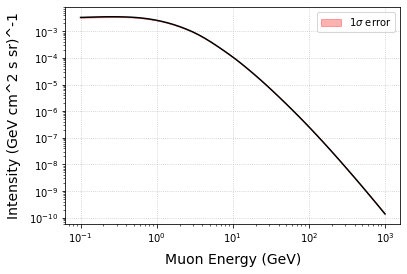

In [41]:
from daemonflux import Flux
import numpy as np
import matplotlib.pyplot as plt

daemonflux = Flux(location='generic')
egrid = np.logspace(-1,3) # Energy in GeV

fl = daemonflux.flux(egrid, '0', 'muflux')/egrid**3
err = daemonflux.error(egrid, '0', 'muflux')/egrid**3
plt.loglog(egrid, fl, color='k')
plt.fill_between(egrid, fl + err, fl - err,
    color='r', alpha=.3, label=r'1$\sigma$ error')
plt.xlabel('Muon Energy (GeV)')
plt.ylabel('Intensity (GeV cm^2 s sr)^-1')
plt.legend()

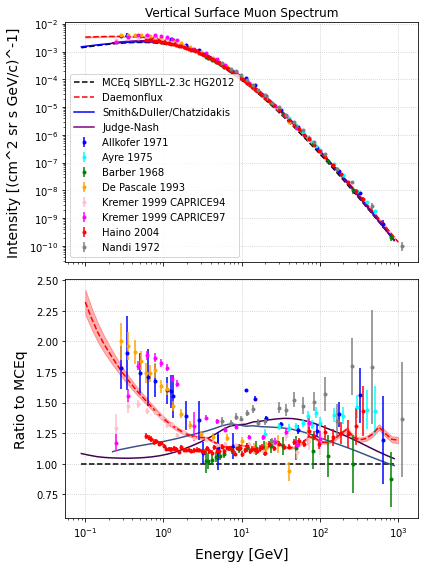

In [42]:
mag = 0

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(6,8), tight_layout=True, sharex=True)

ax1.errorbar(p_avg_A71, F_mu_tot_A71*p_avg_A71**mag, yerr=F_mu_err_A71*p_avg_A71**mag, c='b', fmt='.', label='Allkofer 1971')
ax1.errorbar(p_avg_A75, F_mu_tot_A75*p_avg_A75**mag, yerr=F_mu_err_A75*p_avg_A75**mag, c='cyan', fmt='.', label='Ayre 1975')
ax1.errorbar(p_avg_B68, F_mu_tot_B68*p_avg_B68**mag, yerr=F_mu_err_B68*p_avg_B68**mag, c='green', fmt='.', label='Barber 1968')
ax1.errorbar(p_avg_DP93, (F_mu_neg_DP93+F_mu_pos_DP93)*1e-4*p_avg_DP93**mag, yerr=np.sqrt(F_neg_err_DP93**2+F_pos_err_DP93**2)*1e-4*p_avg_DP93**mag, c='orange', fmt='.', label='De Pascale 1993')
ax1.errorbar(p_avg_K99, F_mu_tot_K99_94*1e-4*p_avg_K99**mag, yerr=F_mu_err_K99_94*1e-4*p_avg_K99**mag, c='pink', fmt='.', label='Kremer 1999 CAPRICE94')
ax1.errorbar(p_avg_K99_97, F_mu_tot_K99_97*1e-4*p_avg_K99_97**mag, yerr=F_mu_err_K99_97*1e-4*p_avg_K99_97**mag, c='magenta', fmt='.', label='Kremer 1999 CAPRICE97')
ax1.errorbar(P_avg_mu_pos_H04, (F_mu_pos_H04+F_mu_neg_H04)[:,0]*1e-4*P_avg_mu_pos_H04**mag, yerr=np.sqrt(np.sum(F_mu_pos_H04[:,1:]**2+F_mu_neg_H04[:,1:]**2,axis=1))*1e-4*P_avg_mu_pos_H04**mag, c='r', fmt='.', label='Haino 2004')
ax1.errorbar(p_avg_N72, F_mu_tot_N72*p_avg_N72**mag, yerr=F_mu_err_N72*p_avg_N72**mag, c='grey', fmt='.', label='Nandi 1972')
ax1.plot(E_grid[E_grid<1e3], (mceq_mu_pos+mceq_mu_neg)[E_grid<1e3]*E_grid[E_grid<1e3]**mag, c='black', ls='--', label='MCEq {} {}'.format(interaction_model, primary_name))
ax1.plot(egrid, fl*egrid**mag, color='r', ls='--', label='Daemonflux')
ax1.fill_between(egrid, (fl + err)*egrid**mag, (fl - err)*egrid**mag,
    color='r', alpha=.3)
ax1.plot(E_grid[E_grid<1e3], F_SDC[E_grid<1e3], c='b', label='Smith&Duller/Chatzidakis')
ax1.plot(E_grid[E_grid<1e3], F_JN[E_grid<1e3], c='purple', label='Judge-Nash')
#ax1.plot(E_grid[E_grid<1e3], F_BR[E_grid<1e3], label='Bugaev-Renya')
#ax1.plot(E_grid[E_grid<1e3], F_G[E_grid<1e3], label='Gaisser')
ax2.plot(E_grid[E_grid<1e3], (mceq_mu_pos+mceq_mu_neg)[E_grid<1e3]/(mceq_mu_pos+mceq_mu_neg)[E_grid<1e3], c='black', ls='--')
ax2.plot(E_grid[E_grid<1e3], F_SDC[E_grid<1e3]/(mceq_mu_pos+mceq_mu_neg)[E_grid<1e3])
ax2.plot(E_grid[E_grid<1e3], F_JN[E_grid<1e3]/(mceq_mu_pos+mceq_mu_neg)[E_grid<1e3])
#ax2.plot(E_grid[E_grid<1e3], F_BR[E_grid<1e3]/(mceq_mu_pos+mceq_mu_neg)[E_grid<1e3])
#ax2.plot(E_grid[E_grid<1e3], F_G[E_grid<1e3]/(mceq_mu_pos+mceq_mu_neg)[E_grid<1e3])
ax2.errorbar(p_avg_A71, F_mu_tot_A71/np.interp(p_avg_A71, E_grid, mceq_mu_pos+mceq_mu_neg), yerr=F_mu_err_A71/np.interp(p_avg_A71, E_grid, mceq_mu_pos+mceq_mu_neg), c='b', fmt='.')
ax2.errorbar(p_avg_A75, F_mu_tot_A75/np.interp(p_avg_A75, E_grid, mceq_mu_pos+mceq_mu_neg), yerr=F_mu_err_A75/np.interp(p_avg_A75, E_grid, mceq_mu_pos+mceq_mu_neg), c='cyan', fmt='.')
ax2.errorbar(p_avg_B68, F_mu_tot_B68/np.interp(p_avg_B68, E_grid, mceq_mu_pos+mceq_mu_neg), yerr=F_mu_err_B68/np.interp(p_avg_B68, E_grid, mceq_mu_pos+mceq_mu_neg), c='green', fmt='.')
ax2.errorbar(p_avg_DP93, (F_mu_neg_DP93+F_mu_pos_DP93)*1e-4/np.interp(p_avg_DP93, E_grid, mceq_mu_pos+mceq_mu_neg), yerr=np.sqrt(F_neg_err_DP93**2+F_pos_err_DP93**2)*1e-4/np.interp(p_avg_DP93, E_grid, mceq_mu_pos+mceq_mu_neg), c='orange', fmt='.')
ax2.errorbar(p_avg_K99, F_mu_tot_K99_94*1e-4/np.interp(p_avg_K99, E_grid, mceq_mu_tot), yerr=F_mu_err_K99_94*1e-4/np.interp(p_avg_K99, E_grid, mceq_mu_tot), fmt='.', c='pink')
ax2.errorbar(p_avg_K99_97, F_mu_tot_K99_97*1e-4/np.interp(p_avg_K99_97, E_grid, mceq_mu_tot), yerr=F_mu_err_K99_97*1e-4/np.interp(p_avg_K99_97, E_grid, mceq_mu_tot), fmt='.', c='magenta')
ax2.errorbar(P_avg_mu_pos_H04, (F_mu_pos_H04+F_mu_neg_H04)[:,0]*1e-4/np.interp(P_avg_mu_pos_H04, E_grid, mceq_mu_pos+mceq_mu_neg), yerr=np.sqrt(np.sum(F_mu_pos_H04[:,1:]**2+F_mu_neg_H04[:,1:]**2,axis=1))*1e-4/np.interp(P_avg_mu_pos_H04, E_grid, mceq_mu_pos+mceq_mu_neg), fmt='.', c='r')
ax2.errorbar(p_avg_N72, F_mu_tot_N72/np.interp(p_avg_N72, E_grid, mceq_mu_pos+mceq_mu_neg), yerr=F_mu_err_N72/np.interp(p_avg_N72, E_grid, mceq_mu_pos+mceq_mu_neg), c='grey', fmt='.')
ax2.plot(egrid, fl/np.interp(egrid, E_grid, mceq_mu_tot), color='r', ls='--', label='Daemonflux')
ax2.fill_between(egrid, (fl + err)/np.interp(egrid, E_grid, mceq_mu_tot), (fl - err)/np.interp(egrid, E_grid, mceq_mu_tot),
    color='r', alpha=.3)

ax1.set(xscale = 'log',
       yscale = 'log',
       ylabel='Intensity [(cm^2 sr s GeV/c)^-1]')
ax1.legend(loc='lower left', fontsize=10)

ax2.set(xscale = 'log',
       xlabel='Energy [GeV]',
       ylabel='Ratio to MCEq')

ax1.title.set_text('Vertical Surface Muon Spectrum')
plt.show()